In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import albumentations as A

In [30]:
# Custom wrapper for albumentations transforms
import numpy as np
from PIL import Image

class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # Convert PIL Image to numpy array
        if isinstance(img, Image.Image):
            img = np.array(img)
        # Apply albumentations transform with named argument
        augmented = self.transform(image=img)
        return augmented['image']

In [31]:
data_dir = './datasets'
#Define the transformations
transforms = AlbumentationsTransform(A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
]))
#upload the dataset
full_dataset = ImageFolder(root=data_dir, transform=transforms)
 #For a third test set, you could adjust the calculation:
train_size = int(0.8 * len(full_dataset))
test_size = int(0.1 * len(full_dataset))
val_size = len(full_dataset) - train_size - test_size

In [32]:
#Get class names and number of classes
class_names = full_dataset.classes
num_classes = len(class_names)
print(f'Classes: {class_names}')
print(f'Number of classes: {num_classes}')

Classes: ['Lab', 'Tree', 'building', 'car', 'person']
Number of classes: 5


In [33]:
#spit the dataset into train, test, and validation sets
torch.manual_seed(42)
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size, val_size])


In [34]:
#define data augmentations
train_transform = AlbumentationsTransform(A.Compose([
    A.RandomCrop(224,224),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
]))

val_transform = AlbumentationsTransform(A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
]))
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform
train_dataset.dataset.transform = train_transform

In [42]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [36]:
#import the model and modify the final layer
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

/home/mohammad-boom/uniProjects/Campus-Classificaton/.venv/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mohammad-boom/uniProjects/Campus-Classificaton/.venv/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
#Freeze all layers except the final layer
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

In [38]:
# Calculate class weights to handle class imbalance
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Extract labels from the train dataset indices
train_labels = [full_dataset.targets[i] for i in train_dataset.indices]

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f'Class weights: {class_weights}')

Class weights: tensor([1.7302, 0.7294, 1.1022, 0.7750, 1.1717])


In [39]:
#Define optimizer and loss function
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [40]:
# change the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check GPU compatibility
if torch.cuda.is_available():
	print(f"GPU: {torch.cuda.get_device_name(0)}")
	print(f"CUDA Version: {torch.version.cuda}")
	print(f"PyTorch Version: {torch.__version__}")
	print(f"GPU Compute Capability: {torch.cuda.get_device_capability(0)}")

# Move model to device
model = model.to(device)
criterion = criterion.to(device)


Using device: cuda
GPU: NVIDIA GeForce MX350
CUDA Version: 12.8
PyTorch Version: 2.9.1+cu128
GPU Compute Capability: (6, 1)


In [50]:
# Check if CUDA is properly configured, otherwise use CPU
try:
    # Test CUDA with a simple operation
    test_tensor = torch.tensor([1.0]).to(device)
    test_result = test_tensor * 2
    print(f"CUDA test passed, using device: {device}")
except RuntimeError as e:
    print(f"CUDA error detected: {e}")
    print("Falling back to CPU")
    device = torch.device("cpu")
    model = model.to(device)
    criterion = criterion.to(device)

num_epochs = 20
train_losses = []
val_losses = []
best_val_accuracy = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f'Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss:.4f}')

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print('Best model saved!')

CUDA test passed, using device: cpu
Epoch 1/20, Loss: 1.0168
Validation Accuracy: 67.20%, Validation Loss: 0.8557
Best model saved!
Epoch 2/20, Loss: 0.9665
Validation Accuracy: 60.75%, Validation Loss: 1.1086
Epoch 3/20, Loss: 1.0080
Validation Accuracy: 70.43%, Validation Loss: 0.8379
Best model saved!
Epoch 4/20, Loss: 0.9438
Validation Accuracy: 65.05%, Validation Loss: 0.8989
Epoch 5/20, Loss: 0.9562
Validation Accuracy: 69.89%, Validation Loss: 0.8813
Epoch 6/20, Loss: 0.9641
Validation Accuracy: 63.44%, Validation Loss: 0.9204
Epoch 7/20, Loss: 0.9756
Validation Accuracy: 66.13%, Validation Loss: 0.9191
Epoch 8/20, Loss: 0.9250
Validation Accuracy: 68.82%, Validation Loss: 0.8390
Epoch 9/20, Loss: 0.9668
Validation Accuracy: 69.89%, Validation Loss: 0.8575
Epoch 10/20, Loss: 0.9803
Validation Accuracy: 72.04%, Validation Loss: 0.8360
Best model saved!
Epoch 11/20, Loss: 0.9237
Validation Accuracy: 67.20%, Validation Loss: 0.8487
Epoch 12/20, Loss: 0.9409
Validation Accuracy: 60.

In [51]:
# measure test accuracy
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 64.52%


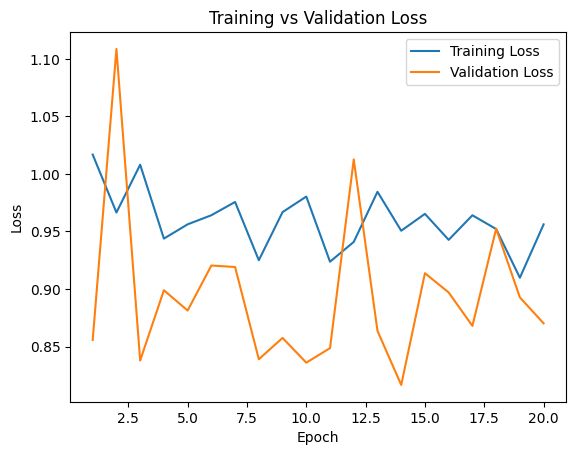

In [52]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()
